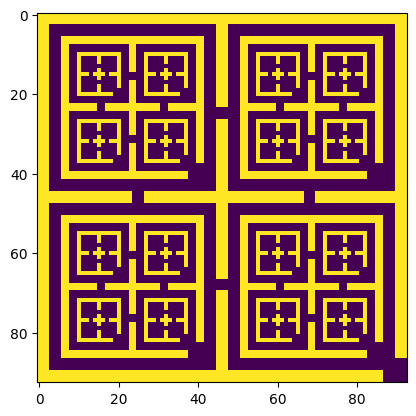

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor
from matplotlib.animation import FuncAnimation
import argparse
import yaml
import math
from pyramid import create_pyramid
from continuous_maze import bfs, get_trajectories, gen_traj, plot_traj, ContinuousGridEnvironment, TrajectoryDataset, LabelDataset
from hyperbolic_networks import HyperbolicMLP, hyperbolic_infoNCE_loss, manifold_map
from networks import StateActionEncoder, StateEncoder, infoNCE_loss
import os
import time
from train_streets import get_maze
import wandb

from train_set import PointCloudEncoder, SetDataset, HyperbolicDeepSet, collate_fn


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
embedding_dim = 2

e1_path = f'models/set_experiment2_hyperbolic_True_epochs_128_temp_0.1_trajectories_10000_order__maze_blocker_embeddingdim_2_gamma_0.1_batch_128_hyp_layers_2_encoder1_epoch_128.pth'
e2_path = f'models/set_experiment2_hyperbolic_True_epochs_128_temp_0.1_trajectories_10000_order__maze_blocker_embeddingdim_2_gamma_0.1_batch_128_hyp_layers_2_encoder1_epoch_128.pth'

hyperbolic=True

manifold = PoincareBall(c=Curvature(value=1.0, requires_grad=True))

if hyperbolic:
    encoder1 = HyperbolicDeepSet(input_dim=2, hidden_dim=64, output_dim=embedding_dim, manifold=manifold).to(device)
    # encoder2 = HyperbolicDeepSet(input_dim=2, hidden_dim=64, output_dim=config.embedding_dim, manifold=manifold).to(device)

else:
    PC = True
    encoder1 = DeepSet(input_dim=2, hidden_dim=64, output_dim=embedding_dim).to(device)
    if PC:
        encoder1 = PointCloudEncoder(input_dim=2, output_dim=embedding_dim).to(device)
    # encoder2 = DeepSet(input_dim=2, hidden_dim=64, output_dim=config.embedding_dim).to(device)

encoder1.load_state_dict(torch.load(e1_path, map_location=torch.device(device)))

# encoder2.load_state_dict(torch.load(e2_path, map_location=torch.device(device)))

<All keys matched successfully>

In [6]:
maze = get_maze('blocker')
dataset = SetDataset(maze, 1000, num_splits=4)

dataset[2]

gamma: 0.1


(array([[ 3.5       , 10.5       ],
        [ 3.00018606, 10.48636096],
        [ 2.52314374, 10.33659238],
        [ 2.02534892, 10.38349989],
        [ 1.53911461, 10.50001681]]),
 array([[ 1.4034691 , 10.01876812],
        [ 1.6597433 ,  9.58943895],
        [ 1.58089998,  9.09569435],
        [ 1.54858902,  8.59673944],
        [ 1.63464665,  8.10420103]]))

torch.Size([14, 2])


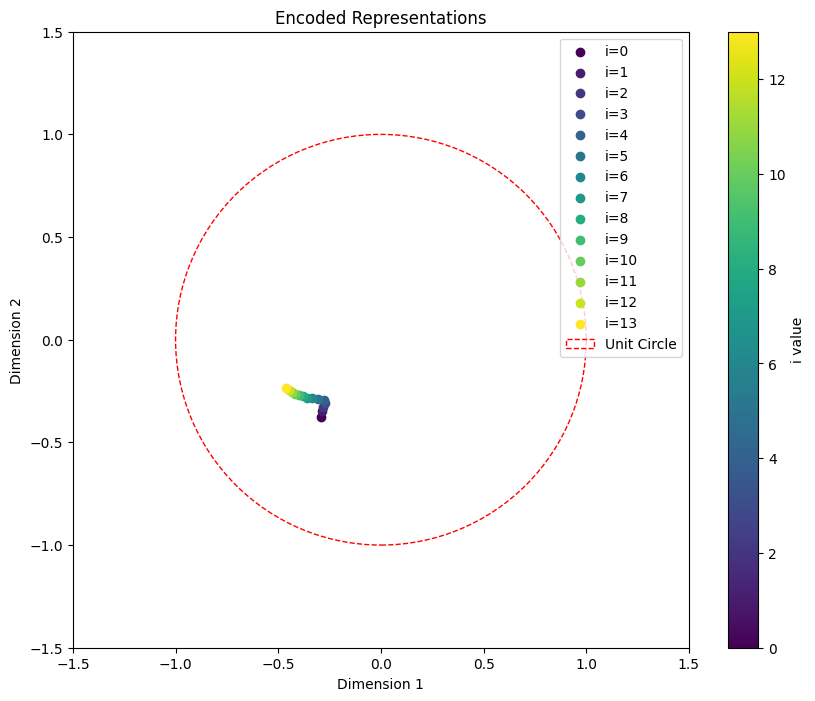

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def view(i):
    val = np.stack([x[0] for x in dataset.trajectories[i]])
    
    l = []
    lens = []
    
    for i in range(1, val.shape[0]):
        l.append(val[:i])
        lens.append(i)
    
    batch = collate_fn([(x, x) for x in l])
    s = batch['set1']
    mask = batch['set1_mask']
   
    s_enc = encoder1(s, mask)
    if hyperbolic:
        s_enc = s_enc.tensor
    print(s_enc.shape)
    with torch.no_grad():
        fig, ax = plt.subplots(figsize=(10, 8))
        # Create a colormap
        cmap = plt.get_cmap('viridis')  # You can change 'viridis' to any other colormap
        # Normalize color values
        norm = mcolors.Normalize(vmin=0, vmax=len(s_enc)-1)
        # Plot each point with a color from the colormap
        for i in range(len(s_enc)):
            scatter = ax.scatter(x=s_enc[i,0], y=s_enc[i,1], 
                        color=cmap(norm(i)), 
                        label=f'i={i}')
        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='i value')
        
        # Add unit circle
        circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', label='Unit Circle')
        ax.add_artist(circle)
        
        # Set limits to ensure the unit circle is centered
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        
        ax.set_title('Encoded Representations')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.legend()
        
        # Ensure the aspect ratio is equal
        ax.set_aspect('equal', adjustable='box')
        
        plt.show()
        
view(0)

[tensor([[6.5508, 1.9974]], dtype=torch.float64), tensor([[6.4061, 2.4760]], dtype=torch.float64), tensor([[6.4422, 2.9747]], dtype=torch.float64), tensor([[6.5900, 3.4524]], dtype=torch.float64), tensor([[6.7396, 3.9295]], dtype=torch.float64), tensor([[6.5201, 4.3787]], dtype=torch.float64), tensor([[6.0206, 4.3567]], dtype=torch.float64), tensor([[5.5230, 4.4056]], dtype=torch.float64), tensor([[5.4729, 4.9031]], dtype=torch.float64), tensor([[5.4206, 5.4003]], dtype=torch.float64), tensor([[4.9313, 5.5034]], dtype=torch.float64), tensor([[4.8855, 6.0013]], dtype=torch.float64), tensor([[4.9453, 6.4977]], dtype=torch.float64), tensor([[4.7783, 6.9690]], dtype=torch.float64), tensor([[4.4725, 7.3646]], dtype=torch.float64), tensor([[4.4950, 7.8641]], dtype=torch.float64), tensor([[4.5909, 8.3548]], dtype=torch.float64), tensor([[4.5062, 8.8476]], dtype=torch.float64), tensor([[4.5809, 9.3420]], dtype=torch.float64), tensor([[4.5914, 9.8418]], dtype=torch.float64), tensor([[ 4.3944, 1

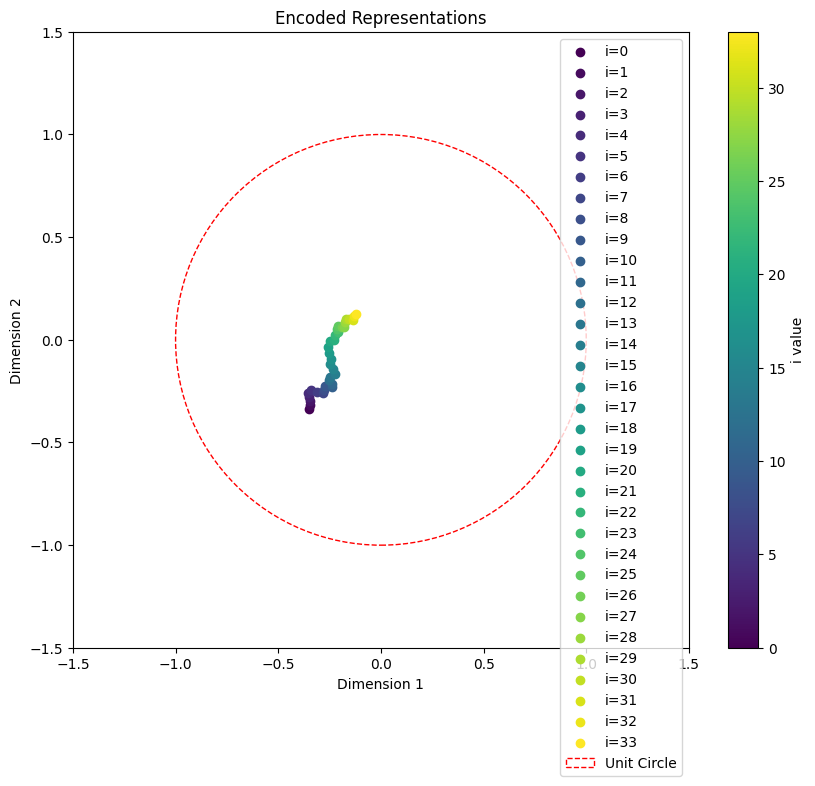

torch.Size([34, 2])


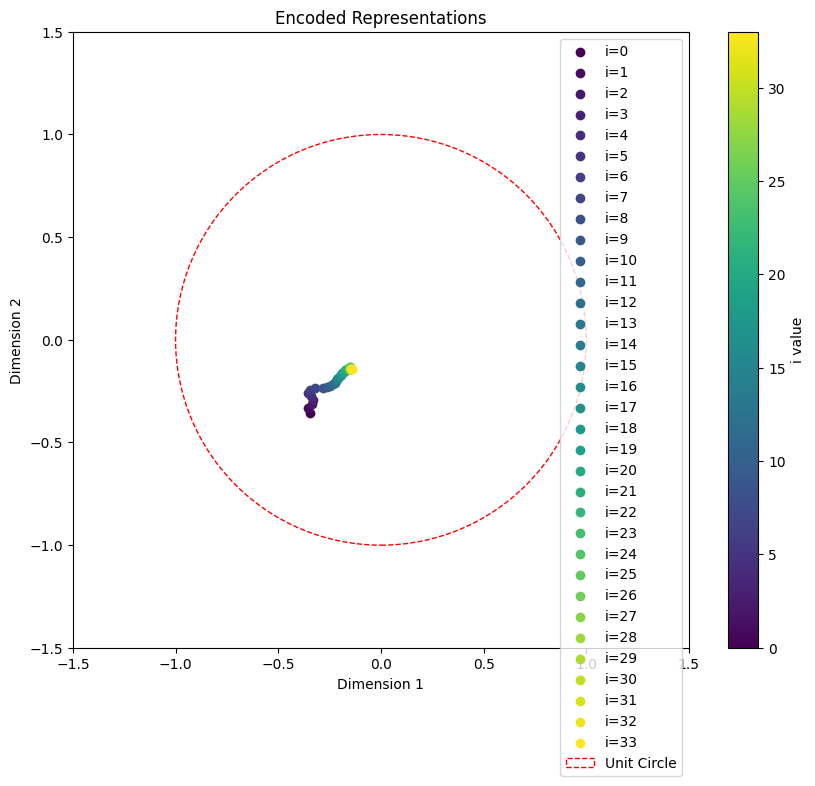

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def view_traj(i):
    val = np.stack([x[0] for x in dataset.trajectories[i]])
    
    l = []
    
    for i in range(1, val.shape[0]):
        l.append(torch.tensor([val[i]]))
    print(l)
    batch = collate_fn([(x, x) for x in l])
    print(batch)
    s = batch['set1']
    mask = batch['set1_mask']
   
    s_enc = encoder1(s, mask)
    if hyperbolic:
        s_enc = s_enc.tensor
    print(s_enc.shape)
    with torch.no_grad():
        fig, ax = plt.subplots(figsize=(10, 8))
        # Create a colormap
        cmap = plt.get_cmap('viridis')  # You can change 'viridis' to any other colormap
        # Normalize color values
        norm = mcolors.Normalize(vmin=0, vmax=len(s_enc)-1)
        # Plot each point with a color from the colormap
        for i in range(len(s_enc)):
            scatter = ax.scatter(x=s_enc[i,0], y=s_enc[i,1], 
                        color=cmap(norm(i)), 
                        label=f'i={i}')
        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='i value')
        
        # Add unit circle
        circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', label='Unit Circle')
        ax.add_artist(circle)
        
        # Set limits to ensure the unit circle is centered
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        
        ax.set_title('Encoded Representations')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.legend()
        
        # Ensure the aspect ratio is equal
        ax.set_aspect('equal', adjustable='box')
        
        plt.show()
       
    
i = 16
view_traj(i)
view(i)

torch.Size([14, 2])


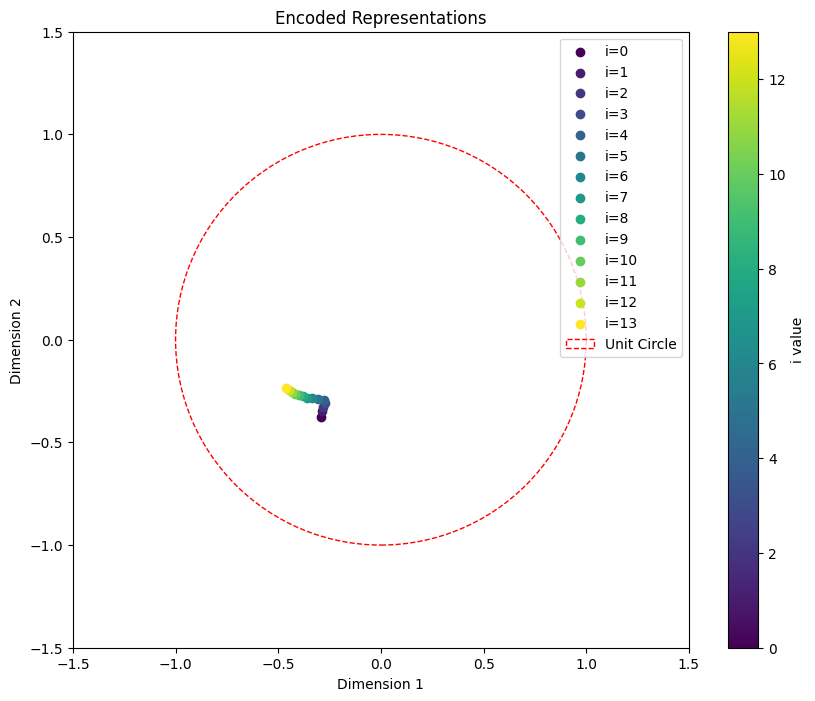

torch.Size([14, 2])


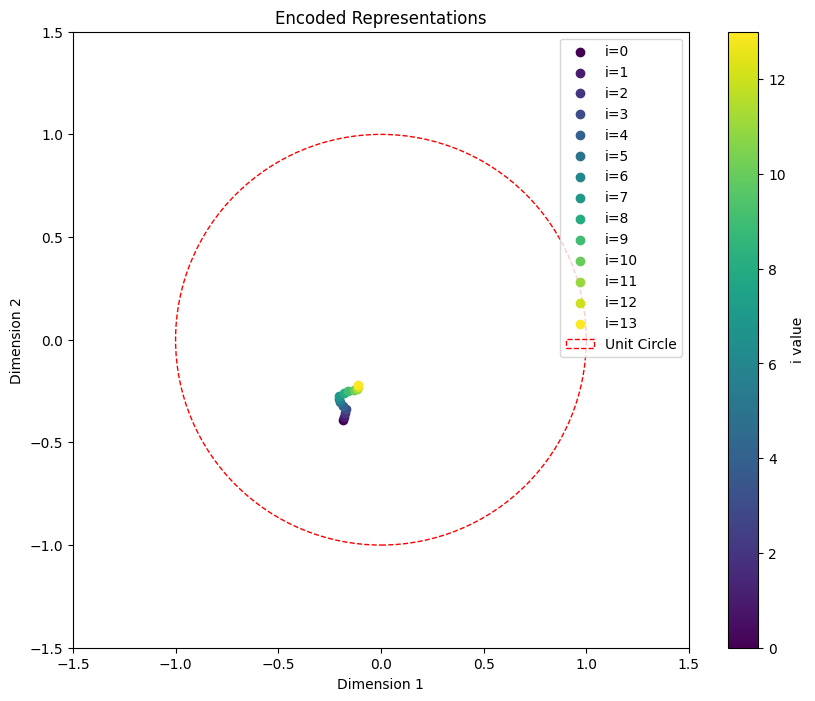

torch.Size([14, 2])


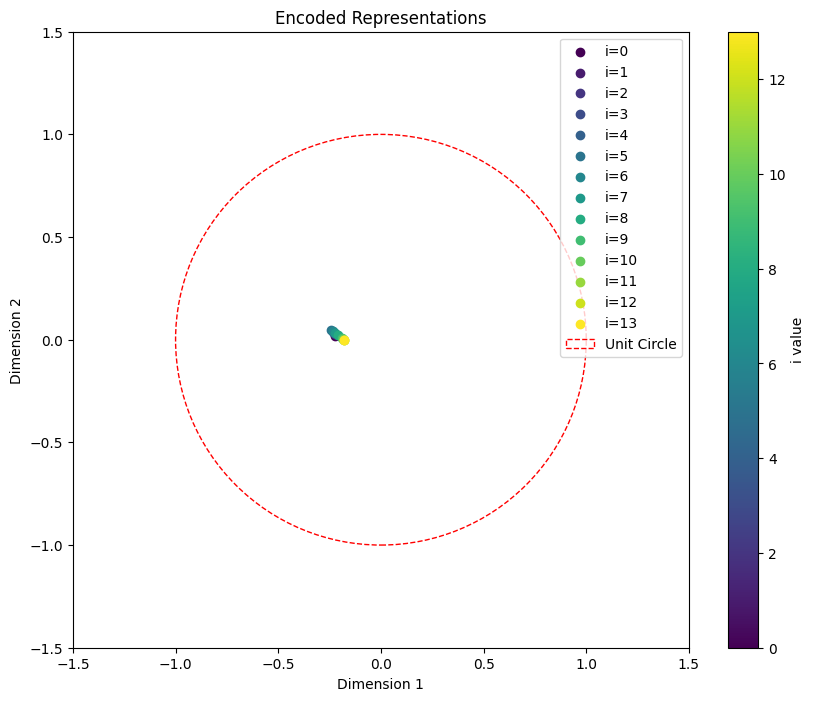

torch.Size([20, 2])


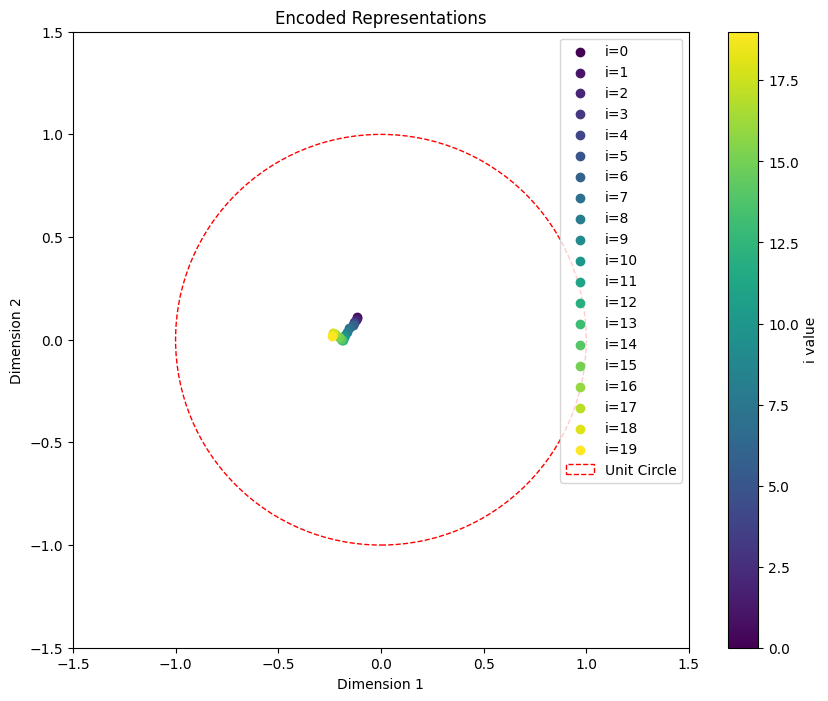

torch.Size([16, 2])


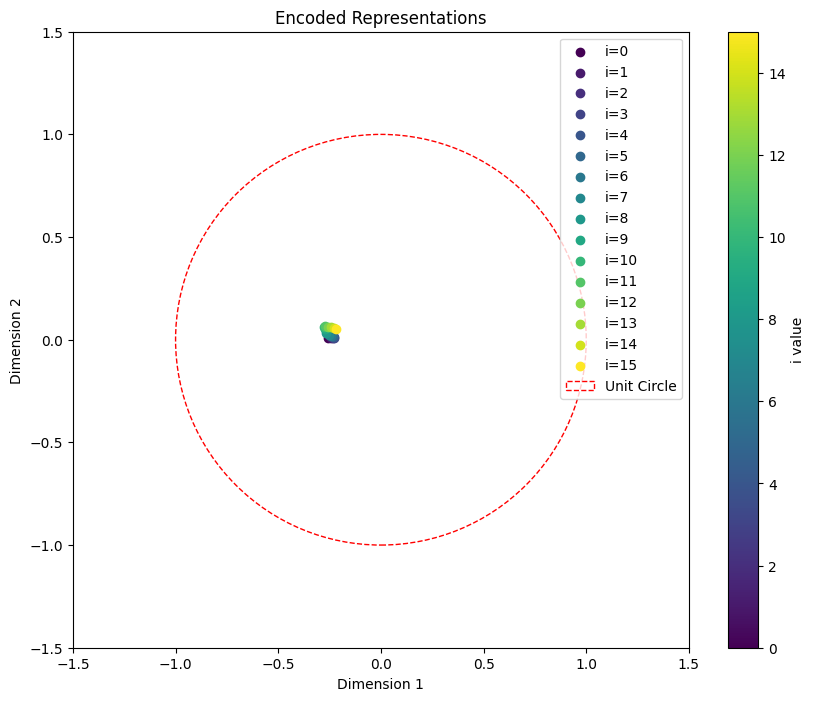

torch.Size([8, 2])


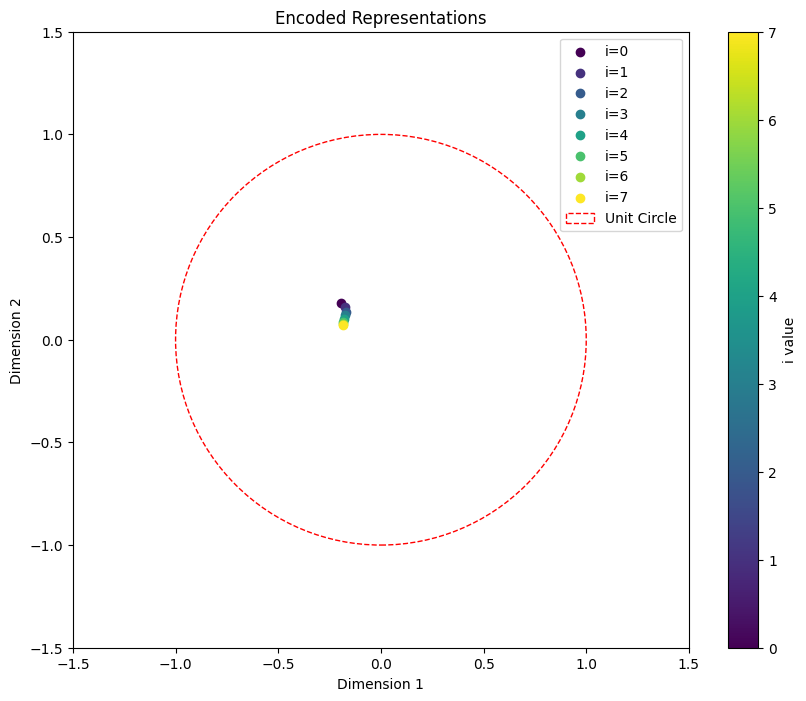

torch.Size([14, 2])


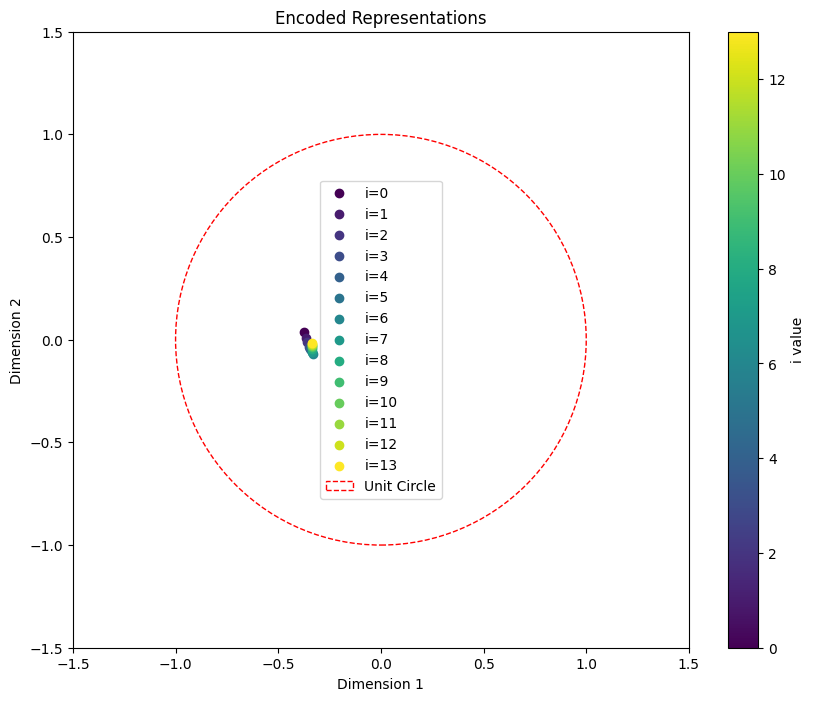

torch.Size([7, 2])


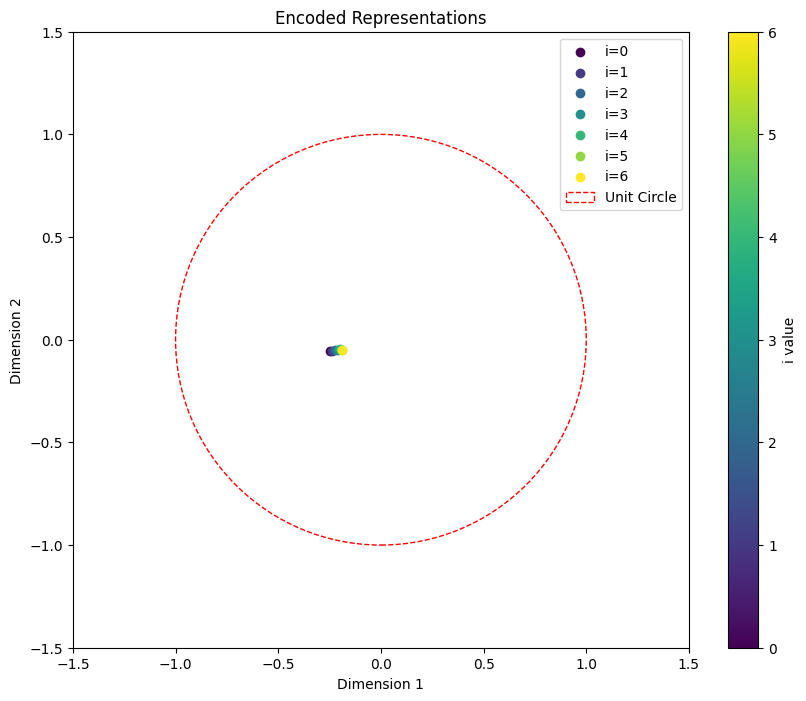

torch.Size([13, 2])


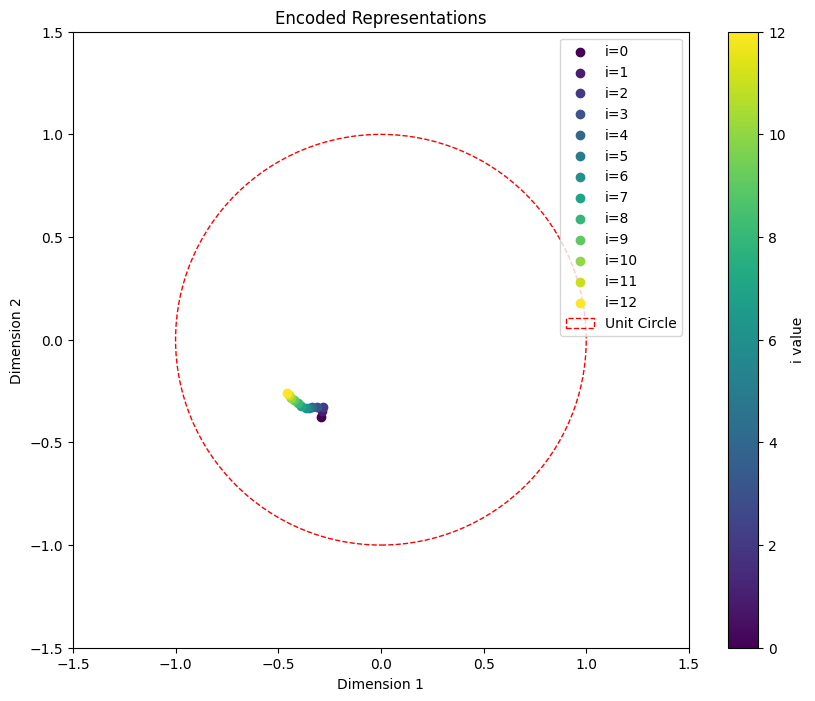

torch.Size([10, 2])


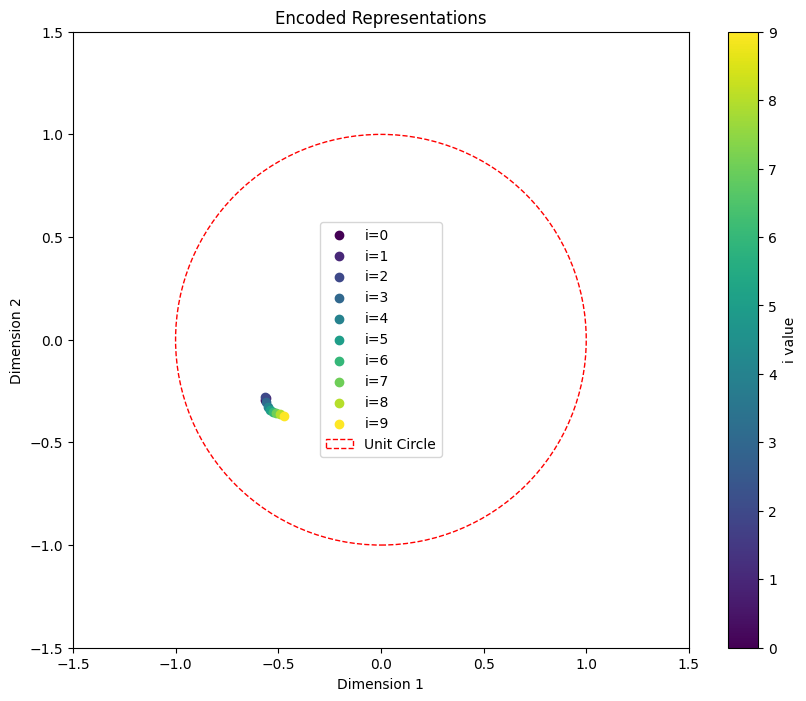

In [8]:
for i in range(10):
    view(i)

torch.Size([25, 2])


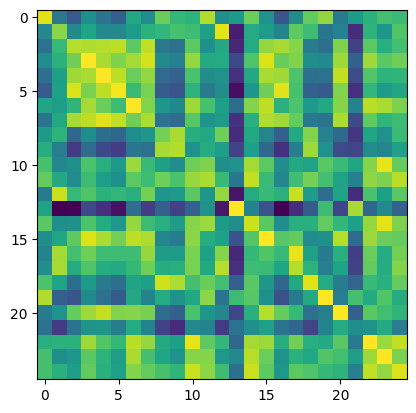

In [9]:
batch = collate_fn([dataset[i] for i in range(25)])


s1 = batch['set1']
s2 = batch['set2']

s1_enc = encoder1(s1, batch['set1_mask'])
s2_enc = encoder1(s2, batch['set2_mask'])

print(s1_enc.shape)
with torch.no_grad():
    if hyperbolic:
        plt.imshow(-manifold.dist(s1_enc.unsqueeze(0), s2_enc.unsqueeze(1)))
    else:
        plt.imshow(-torch.cdist(s1_enc, s2_enc, p=2.0))

In [38]:
with torch.no_grad():
    plt.scatter(x=s1_enc[:,0], y=s1_enc[:,2], color='b')
    plt.scatter(x=s2_enc[:,0], y=s2_enc[:,2], color='r')

ValueError: Attempting to slice into the manifold dimension, but this is not a valid operation

In [13]:
a = torch.randn(size=(32, 100, 2))

encoder1(a)

tensor([[-0.0262,  0.8154],
        [-0.1696, -0.0137],
        [ 0.3480,  0.4876],
        [-0.4686,  0.6231],
        [ 0.1991,  0.4834],
        [ 0.5872,  0.7385],
        [-0.5628,  0.6523],
        [-0.7598,  0.6564],
        [ 0.3324,  0.2025],
        [ 0.2163,  0.4928],
        [-0.0509,  0.2650],
        [ 0.1035,  0.7987],
        [ 0.4027,  0.2370],
        [ 0.0202,  0.3206],
        [-0.2562,  0.3960],
        [ 0.8254,  0.3031],
        [ 0.1960,  0.6969],
        [-0.0206,  0.6168],
        [-0.1103,  0.6017],
        [ 0.4367,  0.2401],
        [ 0.2432, -0.0178],
        [-0.9128,  0.9124],
        [-0.0984,  0.4631],
        [-0.8311,  0.1111],
        [-0.0317,  0.3493],
        [ 0.6118,  0.3960],
        [ 0.6240,  0.4243],
        [-0.3492,  0.4453],
        [ 0.5097,  0.5498],
        [-0.0696,  0.7381],
        [ 0.2113,  0.0781],
        [-0.0168,  0.2130]], grad_fn=<AddmmBackward0>)